In [1]:
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import plot.viz_sequence as viz_sequence
from motif.tfmodisco_hit_scoring import import_tfmodisco_hits
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
import pandas as pd
import scipy.stats
import h5py
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
hits_path = "/users/amtseng/tfmodisco/results/tfmodisco_hit_scoring/multitask_profile_finetune/REST_multitask_profile_finetune_task0_fold7_profile_halfsites/halfsites_only/tfm_matches.bed"
profiles_hdf5_path = "/users/amtseng/tfmodisco/results/peak_predictions/multitask_profile_finetune/REST_multitask_profile_finetune_fold7/REST_multitask_profile_finetune_fold7_pred_perf.h5"
task_index = 0

left_key = "0_7"
right_key = "0_1"

require_unique_config = True

In [4]:
out_path = "/users/amtseng/tfmodisco/figures/rest_motif_spacing/"
os.makedirs(out_path, exist_ok=True)

### Helper functions

In [5]:
def get_binding_strength(coords, profiles_hdf5_path, task_index):
    """
    For the given coordinates as an N x 3 object array (or list of triples),
    obtains the strength of binding as the total read count (averaged over
    strands) for the peak underlying that locus. If there are multiple peak
    matches, takes the peak whose center is closest to the midpoint of the
    coordinate. Returns an N-array.
    """
    scores = np.empty(len(coords))
    
    with h5py.File(profiles_hdf5_path, "r") as f:
        prof_coords_chrom = f["coords"]["coords_chrom"][:].astype(str)
        prof_coords_start = f["coords"]["coords_start"][:]
        prof_coords_end = f["coords"]["coords_end"][:]
        prof_coords_mid = (prof_coords_start + prof_coords_end) // 2
        
        for i in tqdm.notebook.trange(len(coords)):
            chrom, start, end = coords[i]
            mid = (start + end) // 2
            
            match_inds = np.where(
                (prof_coords_chrom == chrom) &
                (prof_coords_start <= start) &
                (prof_coords_end >= end)
            )[0]
            
            if not match_inds.size:
                print("Warning: did not find a peak match for %s:%d-%s" % (chrom, start, end))
            
            mid_dists = np.abs(prof_coords_mid[match_inds] - mid)
            match_ind = match_inds[np.argmin(mid_dists)]
            
            true_count = np.mean(f["predictions"]["true_counts"][match_ind][task_index])
            scores[i] = true_count
    return scores

In [6]:
def find_left_right_instances(subtable, require_unique_config=False):
    """
    From a subtable of a hits table, limited to a single peak, finds if there
    is a left-half and right-half in that order, and returns the coordinate
    and distance between. If there are multiple possible pairs, takes the one
    with the shortest distance between.
    None is returned for the coordinate if no such match is found.
    """
    min_dist, min_coord = float("inf"), None
    chrom = subtable["chrom"].values[0]
    
    for strand in np.unique(subtable["strand"]):
        left_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == left_key)]
        right_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == right_key)]
        
        if require_unique_config:
            if len(left_rows) != 1 or len(right_rows) != 1:
                continue
        else:
            if len(left_rows) < 1 or len(right_rows) < 1:
                continue
        
        for _, left_row in left_rows.iterrows():
            for _, right_row in right_rows.iterrows():
                if strand == "+":
                    dist, coord = right_row["start"] - left_row["end"], (left_row["start"], right_row["end"])
                else:
                    dist, coord = left_row["start"] - right_row["end"], (right_row["start"], left_row["end"])
                if dist >= 0 and dist < min_dist:
                    min_dist, min_coord = dist, coord
        
    return (chrom, min_coord[0], min_coord[1]) if min_coord else None, min_dist

In [7]:
def find_right_left_instances(subtable, require_unique_config=False):
    """
    From a subtable of a hits table, limited to a single peak, finds if there
    is a right-half and left-half in that order, and returns the coordinate
    and distance between. If there are multiple possible pairs, takes the one
    with the shortest distance between.
    None is returned for the coordinate if no such match is found.
    """
    min_dist, min_coord = float("inf"), None
    chrom = subtable["chrom"].values[0]
    
    for strand in np.unique(subtable["strand"]):
        left_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == left_key)]
        right_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == right_key)]
        
        if require_unique_config:
            if len(left_rows) != 1 or len(right_rows) != 1:
                continue
        else:
            if len(left_rows) < 1 or len(right_rows) < 1:
                continue
        
        for _, left_row in left_rows.iterrows():
            for _, right_row in right_rows.iterrows():
                if strand == "+":
                    dist, coord = left_row["start"] - right_row["end"], (right_row["start"], left_row["end"])
                else:
                    dist, coord = right_row["start"] - left_row["end"], (left_row["start"], right_row["end"])
                if dist >= 0 and dist < min_dist:
                    min_dist, min_coord = dist, coord
        
    return (chrom, min_coord[0], min_coord[1]) if min_coord else None, min_dist

In [8]:
def find_full_left_instances(subtable, require_unique_config=False):
    """
    From a subtable of a hits table, limited to a single peak, finds if there
    is a canonical full and left-half in that order, and returns the coordinate
    and distance between. If there are multiple possible pairs, takes the one
    with the shortest distance between.
    None is returned for the coordinate if no such match is found.
    """
    min_dist, min_coord = float("inf"), None
    chrom = subtable["chrom"].values[0]
    
    for strand in np.unique(subtable["strand"]):
        left_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == left_key)]
        right_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == right_key)]
        
        if require_unique_config:
            if len(left_rows) != 2 or len(right_rows) != 1:
                continue
        else:
            if len(left_rows) < 2 or len(right_rows) < 1:
                continue
        
        # First, find all full canonical motifs
        full_coords = []
        for _, left_row in left_rows.iterrows():
            for _, right_row in right_rows.iterrows():
                if strand == "+" and left_row["end"] == right_row["start"]:
                    full_coords.append((left_row["start"], right_row["end"]))
                elif strand == "-" and right_row["end"] == left_row["start"]:
                    full_coords.append((right_row["start"], left_row["end"]))
        
        # Next, find the half motif after each full motif
        for full_start, full_end in full_coords:
            for _, left_row in left_rows.iterrows():
                if strand == "+":
                    dist, coord = left_row["start"] - full_end, (full_start, left_row["end"])
                else:
                    dist, coord = full_start - left_row["end"], (left_row["start"], full_end)
                if dist >= 0 and dist < min_dist:
                    min_dist, min_coord = dist, coord
        
    return (chrom, min_coord[0], min_coord[1]) if min_coord else None, min_dist

In [9]:
def find_full_right_instances(subtable, require_unique_config=False):
    """
    From a subtable of a hits table, limited to a single peak, finds if there
    is a canonical full and right-half in that order, and returns the coordinate
    and distance between. If there are multiple possible pairs, takes the one
    with the shortest distance between.
    None is returned for the coordinate if no such match is found.
    """
    min_dist, min_coord = float("inf"), None
    chrom = subtable["chrom"].values[0]
    
    for strand in np.unique(subtable["strand"]):
        left_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == left_key)]
        right_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == right_key)]
        
        if require_unique_config:
            if len(left_rows) != 1 or len(right_rows) != 2:
                continue
        else:
            if len(left_rows) < 1 or len(right_rows) < 2:
                continue
        
        # First, find all full canonical motifs
        full_coords = []
        for _, left_row in left_rows.iterrows():
            for _, right_row in right_rows.iterrows():
                if strand == "+" and left_row["end"] == right_row["start"]:
                    full_coords.append((left_row["start"], right_row["end"]))
                elif strand == "-" and right_row["end"] == left_row["start"]:
                    full_coords.append((right_row["start"], left_row["end"]))
        
        # Next, find the half motif after each full motif
        for full_start, full_end in full_coords:
            for _, right_row in right_rows.iterrows():
                if strand == "+":
                    dist, coord = right_row["start"] - full_end, (full_start, right_row["end"])
                else:
                    dist, coord = full_start - right_row["end"], (right_row["start"], full_end)
                if dist >= 0 and dist < min_dist:
                    min_dist, min_coord = dist, coord
        
    return (chrom, min_coord[0], min_coord[1]) if min_coord else None, min_dist

### REST motif spacing

In [10]:
# Import motif hits for left and right halves
hit_table = import_tfmodisco_hits(hits_path)

# Trim to the motif hits to a canonical size and strand:
# Left half (0_7): TTCAGCACCG (+)
# Right half (0_1): TGGACAGCG (+)
# This way, the canonical motif is with a spacer of 0 bp
new_strands = np.full(len(hit_table), "")
new_starts = np.zeros(len(hit_table), dtype=int)
new_ends = np.zeros(len(hit_table), dtype=int)

left_pos_mask = (hit_table["key"] == left_key) & (hit_table["strand"] == "+")
new_strands[left_pos_mask] = "-"
new_starts[left_pos_mask] = hit_table[left_pos_mask]["start"] + 15
new_ends[left_pos_mask] = hit_table[left_pos_mask]["end"]
left_neg_mask = (hit_table["key"] == left_key) & (hit_table["strand"] == "-")
new_strands[left_neg_mask] = "+"
new_starts[left_neg_mask] = hit_table[left_neg_mask]["start"]
new_ends[left_neg_mask] = hit_table[left_neg_mask]["end"] - 15

right_pos_mask = (hit_table["key"] == right_key) & (hit_table["strand"] == "+")
new_strands[right_pos_mask] = "-"
new_starts[right_pos_mask] = hit_table[right_pos_mask]["start"] + 2
new_ends[right_pos_mask] = hit_table[right_pos_mask]["end"] - 2
right_neg_mask = (hit_table["key"] == right_key) & (hit_table["strand"] == "-")
new_strands[right_neg_mask] = "+"
new_starts[right_neg_mask] = hit_table[right_neg_mask]["start"] + 2
new_ends[right_neg_mask] = hit_table[right_neg_mask]["end"] - 2

hit_table["strand"] = new_strands
hit_table["start"] = new_starts
hit_table["end"] = new_ends

In [11]:
# Collapse motifs properly, using trimmed motifs
trimmed_hits_path = os.path.join(out_path, "hits_trimmed.bed")
collapsed_hits_path = os.path.join(out_path, "hits_trimmed_collapsed.bed")

# Write trimmed motifs to file
hit_table.to_csv(trimmed_hits_path, sep="\t", header=False, index=False)

# Collapse trimmed motifs when there is at least 1 bp overlapping
!python /users/amtseng/tfmodisco/src/motif/collapse_motif_hits.py {trimmed_hits_path} 7 -s -d -1 > {collapsed_hits_path}

# Import collapsed motif hits
hit_table = import_tfmodisco_hits(collapsed_hits_path)

In [12]:
# Iterating through peaks, find instances of configurations of interest
left_right_coords, left_right_dists = [], []
right_left_coords, right_left_dists = [], []
full_left_coords, full_left_dists = [], []
full_right_coords, full_right_dists = [], []

for peak_index, subtable in tqdm.notebook.tqdm(hit_table.groupby("peak_index")):
    num_left = np.sum(subtable["key"] == left_key)
    num_right = np.sum(subtable["key"] == right_key)
    
    left_right_coord, left_right_dist = find_left_right_instances(subtable, require_unique_config)
    if left_right_coord:
        left_right_coords.append(left_right_coord)
        left_right_dists.append(left_right_dist)
    
    right_left_coord, right_left_dist = find_right_left_instances(subtable, require_unique_config)
    if right_left_coord:
        right_left_coords.append(right_left_coord)
        right_left_dists.append(right_left_dist)

    full_left_coord, full_left_dist = find_full_left_instances(subtable, require_unique_config)
    if full_left_coord:
        full_left_coords.append(full_left_coord)
        full_left_dists.append(full_left_dist)
        
    full_right_coord, full_right_dist = find_full_right_instances(subtable, require_unique_config)
    if full_right_coord:
        full_right_coords.append(full_right_coord)
        full_right_dists.append(full_right_dist)

  0%|          | 0/4512 [00:00<?, ?it/s]

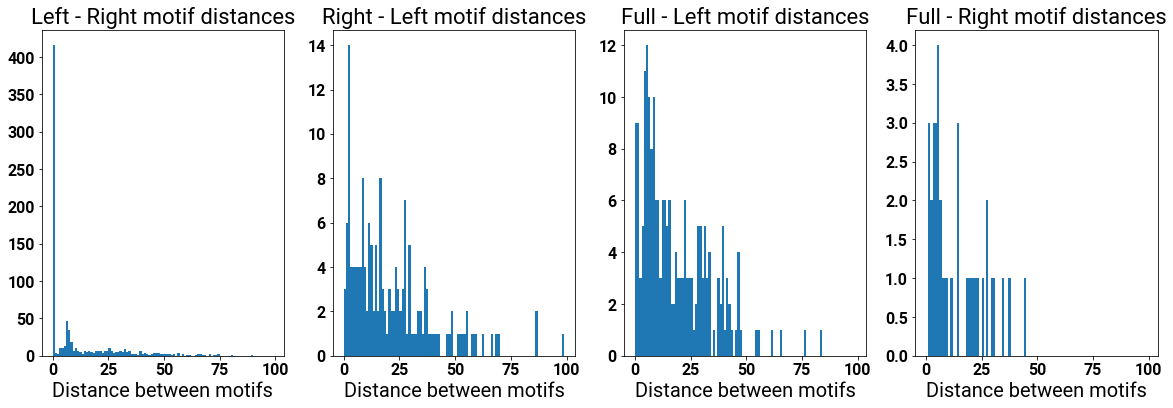

In [13]:
# Plot the distance histograms for each configuration of interest
fig, ax = plt.subplots(ncols=4, figsize=(20, 6), sharex=True)
bins = np.arange(0, 100, 1)
ax[0].hist(left_right_dists, bins=bins)
ax[0].set_title("Left - Right motif distances")
ax[1].hist(right_left_dists, bins=bins)
ax[1].set_title("Right - Left motif distances")
ax[2].hist(full_left_dists, bins=bins)
ax[2].set_title("Full - Left motif distances")
ax[3].hist(full_right_dists, bins=bins)
ax[3].set_title("Full - Right motif distances")

for i in range(4):
    ax[i].set_xlabel("Distance between motifs")

In [14]:
# Extract binding strength at each coordinate of interest
left_right_scores = get_binding_strength(left_right_coords, profiles_hdf5_path, task_index)
right_left_scores = get_binding_strength(right_left_coords, profiles_hdf5_path, task_index)
full_left_scores = get_binding_strength(full_left_coords, profiles_hdf5_path, task_index)
full_right_scores = get_binding_strength(full_right_coords, profiles_hdf5_path, task_index)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

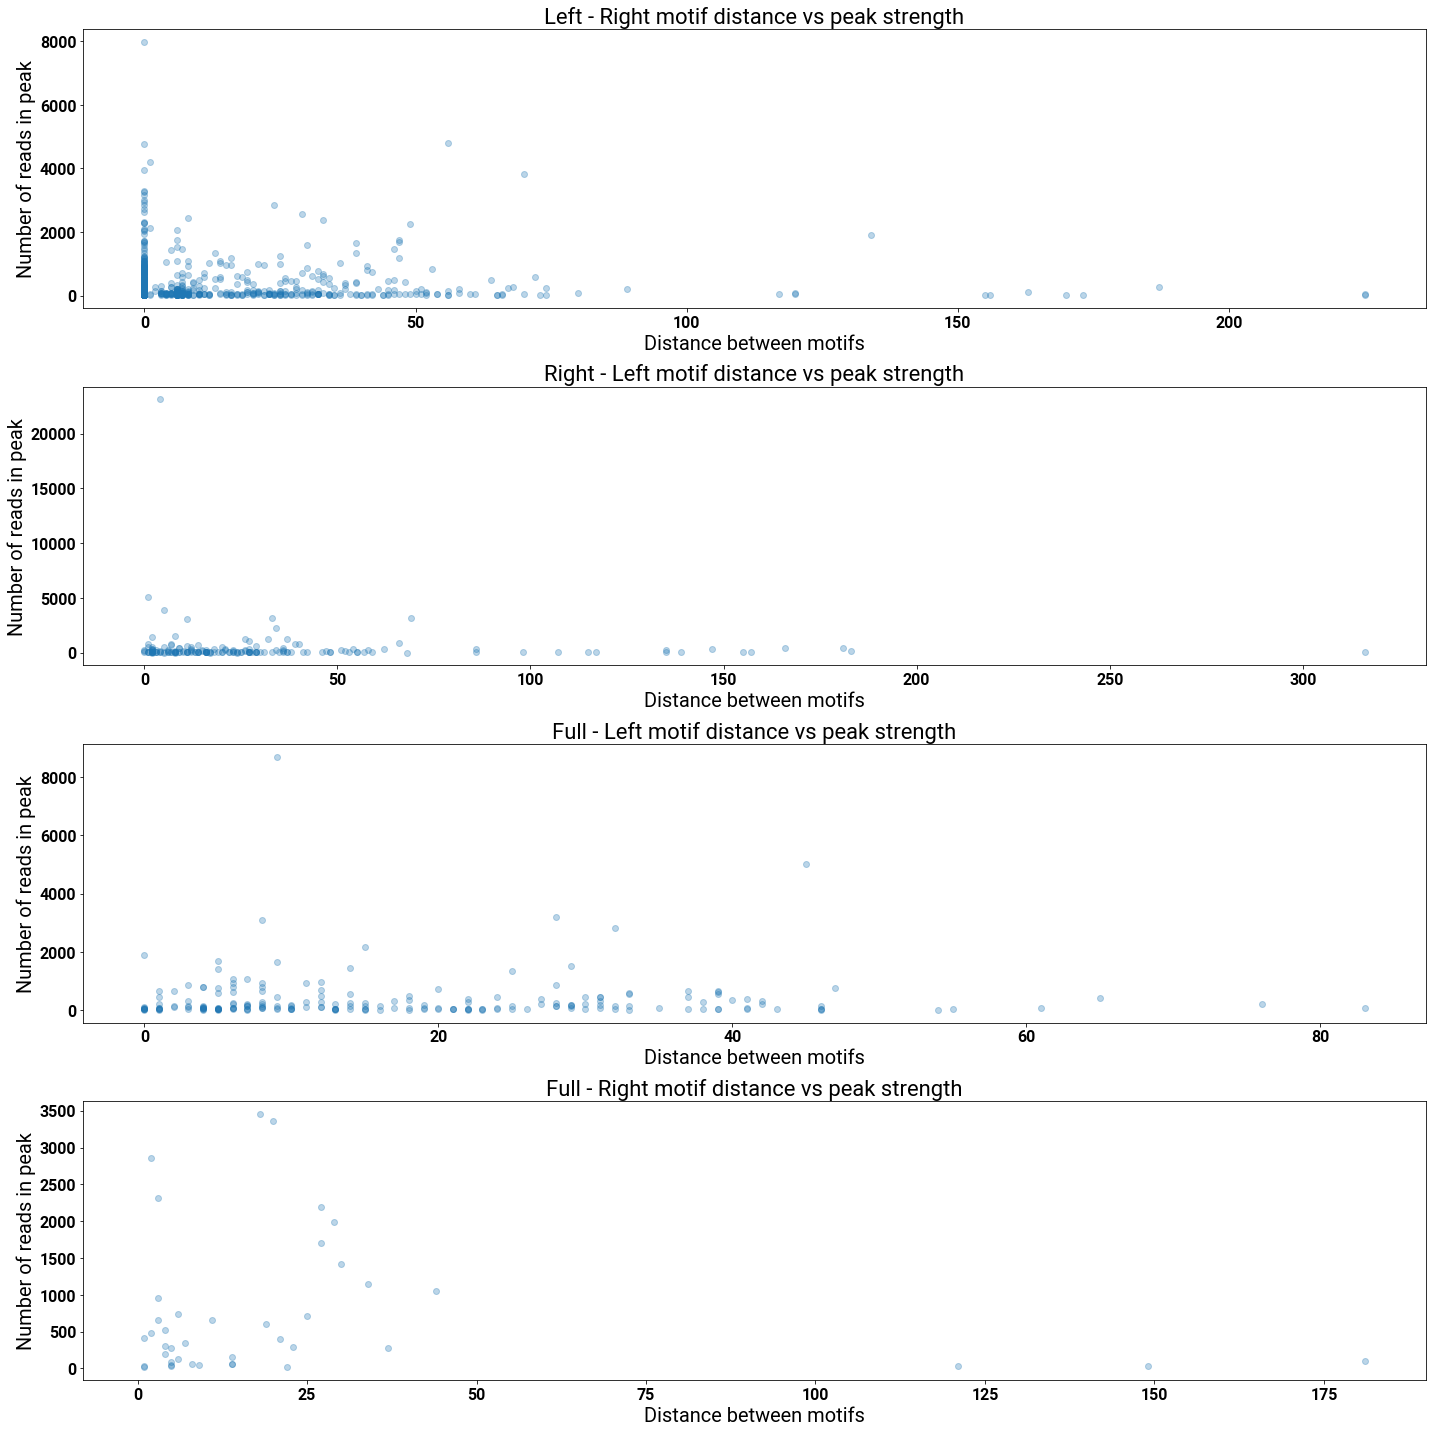

In [15]:
# Plot correspondence between binding strength and distance as a scatterplot
fig, ax = plt.subplots(nrows=4, figsize=(20, 20))
ax[0].scatter(left_right_dists, left_right_scores, alpha=0.3)
ax[0].set_title("Left - Right motif distance vs peak strength")
ax[1].scatter(right_left_dists, right_left_scores, alpha=0.3)
ax[1].set_title("Right - Left motif distance vs peak strength")
ax[2].scatter(full_left_dists, full_left_scores, alpha=0.3)
ax[2].set_title("Full - Left motif distance vs peak strength")
ax[3].scatter(full_right_dists, full_right_scores, alpha=0.3)
ax[3].set_title("Full - Right motif distance vs peak strength")

for i in range(4):
    ax[i].set_xlabel("Distance between motifs")
    ax[i].set_ylabel("Number of reads in peak")
    
fig.tight_layout()

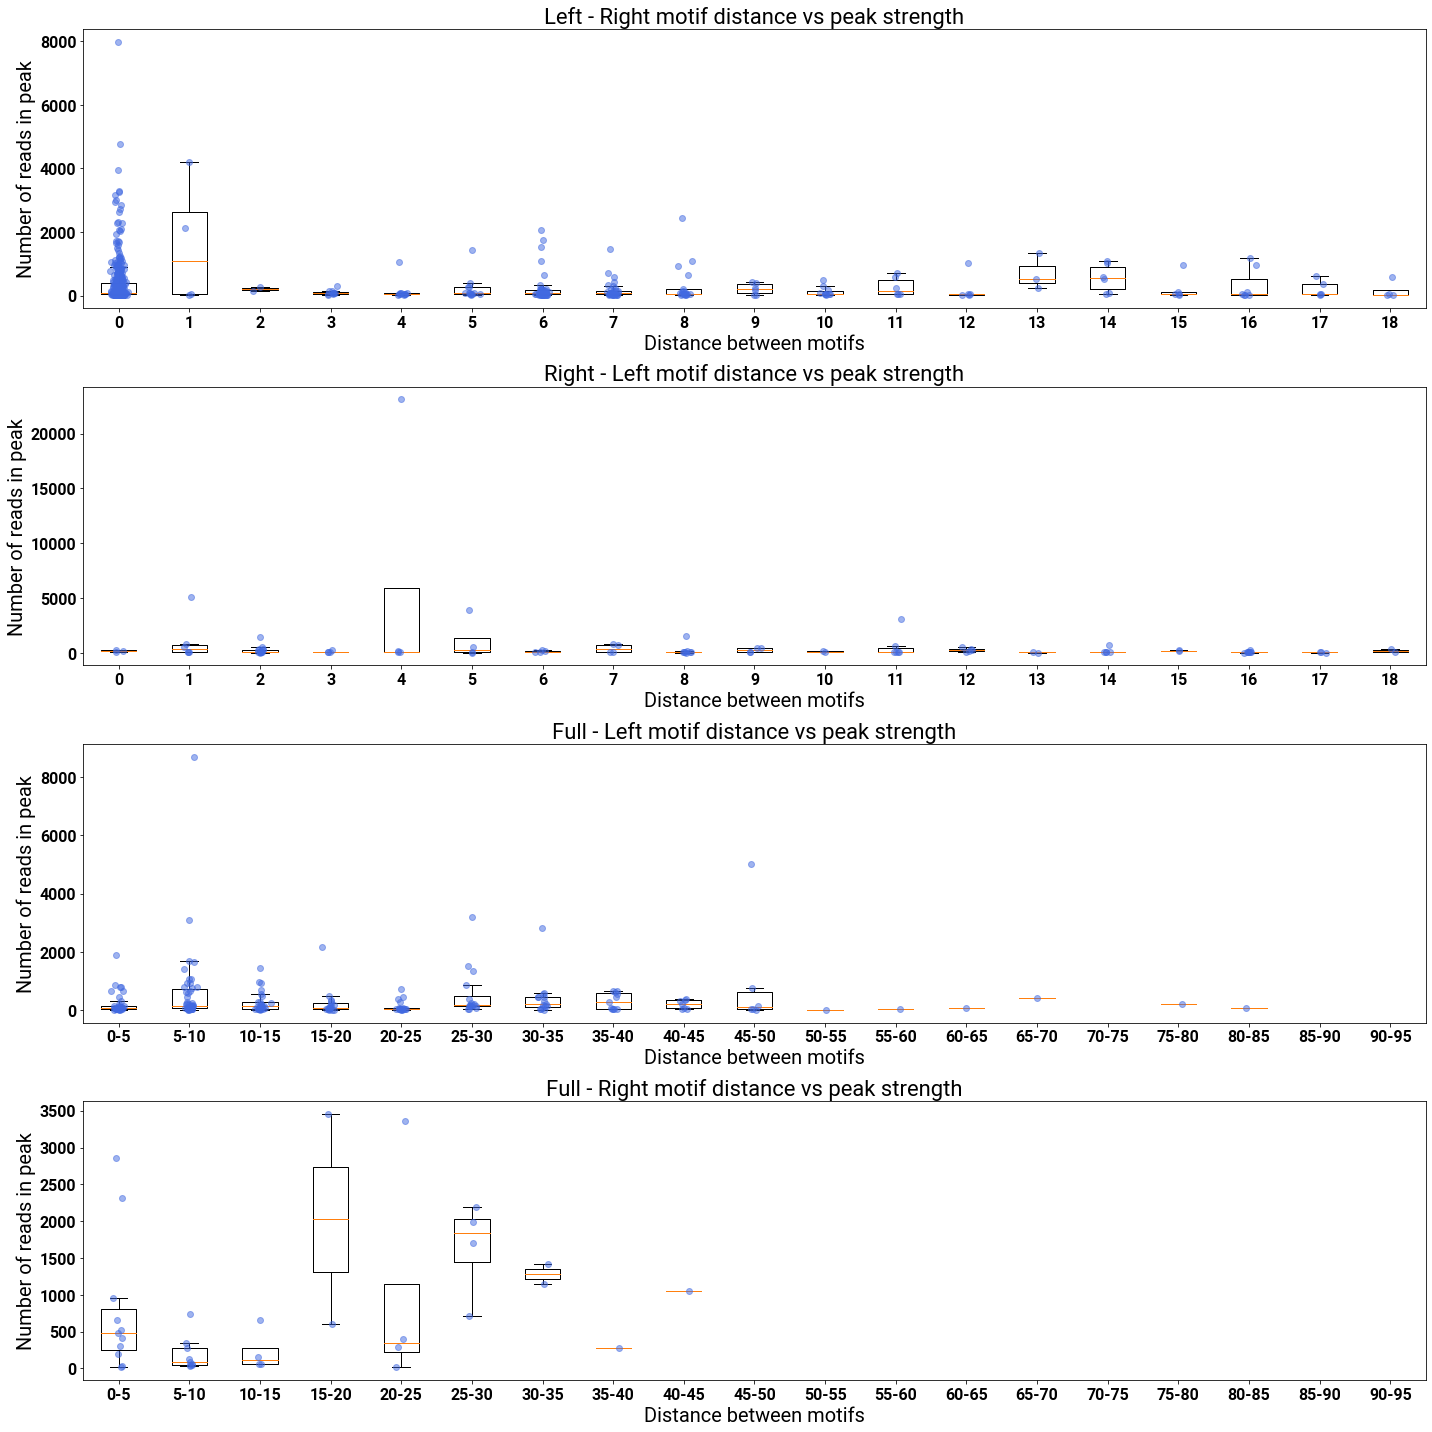

In [16]:
# Plot correspondence between binding strength and distance as a scatterplot
def plot_boxplots(ax, x, y, bins):
    bin_ys, labels = [], []
    for i in range(len(bins) - 1):
        start, end = bins[i], bins[i + 1]
        mask = (x >= start) & (x < end)
        bin_ys.append(y[mask])
        if end - start == 1:
            labels.append(str(start))
        else:
            labels.append("%d-%d" % (start, end))
        
    ax.boxplot(bin_ys, showfliers=False, zorder=0)
    for i, bin_y in enumerate(bin_ys):
        x = np.random.normal(i + 1, 0.04, len(bin_y))
        ax.scatter(x, bin_y, alpha=0.5, color="royalblue", zorder=1)
    ax.set_xticklabels(labels)

fig, ax = plt.subplots(nrows=4, figsize=(20, 20))
plot_boxplots(ax[0], left_right_dists, left_right_scores, np.arange(0, 20, 1))
ax[0].set_title("Left - Right motif distance vs peak strength")
plot_boxplots(ax[1], right_left_dists, right_left_scores, np.arange(0, 20, 1))
ax[1].set_title("Right - Left motif distance vs peak strength")
plot_boxplots(ax[2], full_left_dists, full_left_scores, np.arange(0, 100, 5))
ax[2].set_title("Full - Left motif distance vs peak strength")
plot_boxplots(ax[3], full_right_dists, full_right_scores, np.arange(0, 100, 5))
ax[3].set_title("Full - Right motif distance vs peak strength")

for i in range(4):
    ax[i].set_xlabel("Distance between motifs")
    ax[i].set_ylabel("Number of reads in peak")
    
fig.tight_layout()